In [1]:
remotes::install_github("peeter-t2/digar.txts",lib="R_pckg/",upgrade="never")
library(digar.txts,lib.loc="R_pckg/")

* checking for file ‘/tmp/RtmprHFIkJ/remotesfdfe45252c69/peeter-t2-digar.txts-b87e10a/DESCRIPTION’ ... OK
* preparing ‘digar.txts’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘digar.txts_0.0.0.9100.tar.gz’
Warning in sprintf(gettext(fmt, domain = domain), ...) :
  one argument not used by format 'invalid uid value replaced by that for user 'nobody''



Loading required package: data.table



In [2]:
library(tidyverse)
library(igraph)
install.packages('tidytext', lib='~/R_pckg')
library(tidytext, lib.loc='~/R_pckg')
install.packages('ggraph', lib='~/R_pckg')
library(ggraph, lib.loc='~/R_pckg')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose

In [3]:
all_issues <- get_digar_overview()

[1] "Issue metadata read"


In [4]:
stopsonad <- read.table("estonian-stopwords-lemmas.txt", header = TRUE, sep = "\t", encoding = "UTF-8", stringsAsFactors = T)

In [5]:
rootsi_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="estdagbladet" | keyid=="eestiteatajastock" | keyid=="stockholmstid" | keyid=="teatajapoliit" | keyid=="valiseesti")

In [6]:
searchterm <- "balti"
searchfile <- "balti_lemmad_rootsi.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, rootsi_ajalehed, searchtype="lemmas", source="pages")

In [7]:
texts2 <- fread("balti_lemmad_rootsi.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts2[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta2 <- texts2 %>% select(id, DocumentID) %>% left_join(rootsi_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [8]:
rootsi_bigrammid <- get_concordances(searchterm=searchterm,texts=texts2,before=50,after=50,txt="lemmas",id="id")

In [9]:
rootsi_concs <- rootsi_bigrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(rootsi_concs, "rootsi_bigrammid.txt", sep="\t", quote = F, row.names = F)

In [10]:
rootsi_concs2 <- str_replace_all(rootsi_concs$context, "\\|", "_")

rootsi_concs3 <- as.data.frame(rootsi_concs2, header = TRUE)
colnames(rootsi_concs3) <- "context"
head(rootsi_concs3, 10)

,context
,<chr>
1,"uma_kutsutud eesti , läti ja leedu rahvas esindus balti komitee . eestlane esindaja võtma komitee juhtimi"
2,d Moskva ka Türgi välispoliitika juht Saraeoglu . balti maa esindaja olema sundima_sunnitud andma_antud o
3,"elgia Taani Kopenhaagen , 28. juuli . Kopenhaagen balti põgenik laager jõudma eestlane , kes oma põgenemi"
4,kes kõik olema nn . Baltikum laager . üldse olema balti riik kodanik seal umbes 100 inimene . teine eestl
5,"valdama_avaldatud . Unrra poolt teatama veel , et balti riik kodaku_kodakud , kes oma kodumaa tagasi ei t"
6,nike praktiseerimine võimalus laiendama . Arste - balti põgenik tahtma rakendama Rootsi Punane_Punas Rist
7,"rd kuulma , et Potsdam võima päevakord kerkima ka balti riik tulevik küsimus . teatavasti ei olema Inglis"
8,e kodanik . 970 see olema haige ja ülejäänu olema balti maa . Inglis ametivõim ei vaatama aga tema kui ’‘
9,aheline organisatsioon esindaja Poolamaa ja teine balti maa ; 4 ) nõukogu vene sõjavägi lahkumine Poolaj


In [11]:
bigrams_separated_rootsi <- rootsi_concs3 %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2, n_min = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [12]:
bigrams_filtered_rootsi <- bigrams_separated_rootsi %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [13]:
bigram_counts_rootsi <- bigrams_filtered_rootsi %>% 
  count(word1, word2, sort = TRUE)

In [14]:
bigram_graph_rootsi <- bigram_counts_rootsi %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

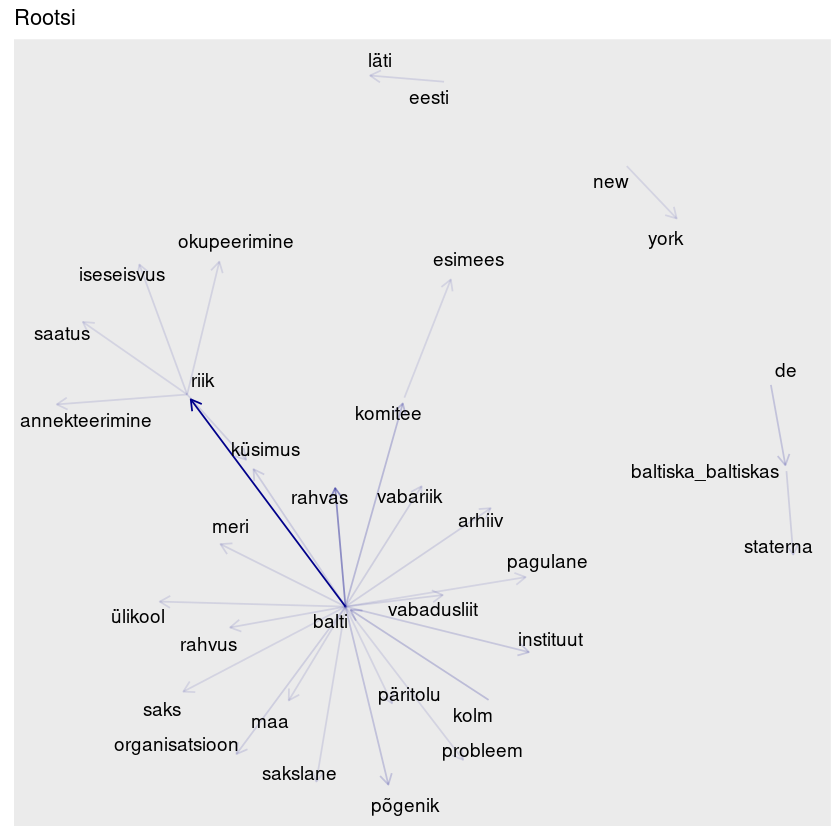

In [15]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_rootsi, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("Rootsi")

In [16]:
kanada_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestlane" | keyid=="voitleja")

In [17]:
searchfile <- "balti_lemmad_kanada.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, kanada_ajalehed, searchtype="lemmas", source="pages")

In [18]:
texts3 <- fread("balti_lemmad_kanada.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts3[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta3 <- texts3 %>% select(id, DocumentID) %>% left_join(kanada_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [19]:
kanada_bigrammid <- get_concordances(searchterm=searchterm,texts=texts3,before=50,after=50,txt="lemmas",id="id")

In [20]:
kanada_concs <- kanada_bigrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(kanada_concs, "kanada_bigrammid.txt", sep="\t", quote = F, row.names = F)

In [21]:
kanada_concs2 <- str_replace_all(kanada_concs$context, "\\|", "_")

kanada_concs3 <- as.data.frame(kanada_concs2, header = TRUE)
colnames(kanada_concs3) <- "context"
head(kanada_concs3, 10)

,context
,<chr>
1,m kontakt ja eriti südamik ja tihe olema see kolm balti rahvas vahel . riiginõukogu liige min . J. Müller
2,as ja Eesti koguni kahjulik . mis tahtma sakslane balti riik maa-ala suurendamine saavutama ? pidama meel
3,"enemaa nõrgestama . Venemaa külg maa äralõikamine balti .. Generalhezirk_Generalhezirki """""""" suurendamine"
4,iis äratama see ajakiri number suur tähelepanu ka balti põgenik keskel . Eesti pagnlasajakirjandus olema
5,"kelaager , kus pögenikuteekond algul asuma ainult balti rahvas . Omalajal tõusma seal eestlane arv ligi 2"
6,"a tähendama_tähendanud , et kõik põgenik , rahvus balti meri kuni must meri , olema läänemaailm põgenema_"
7,see sobivus või ka erakondlik side järg jne . ka balti riik paneel koosseis olema kuuldus järgi huvitama
8,dud_Liit port vägivaldselt okupeerima_okupeeritud balti riik olukord . Ester Rõhl sina suur imensiivsus s
9,"ka I R-cxMsiF leiduma veel ringkond , kes pidama balti riik anastamine enamlane 3 , , i kommunistlik par"


In [22]:
bigrams_separated_kanada <- kanada_concs3 %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2, n_min = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [23]:
bigrams_filtered_kanada <- bigrams_separated_kanada %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [24]:
bigram_counts_kanada <- bigrams_filtered_kanada %>% 
  count(word1, word2, sort = TRUE)

In [25]:
bigram_graph_kanada <- bigram_counts_kanada %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

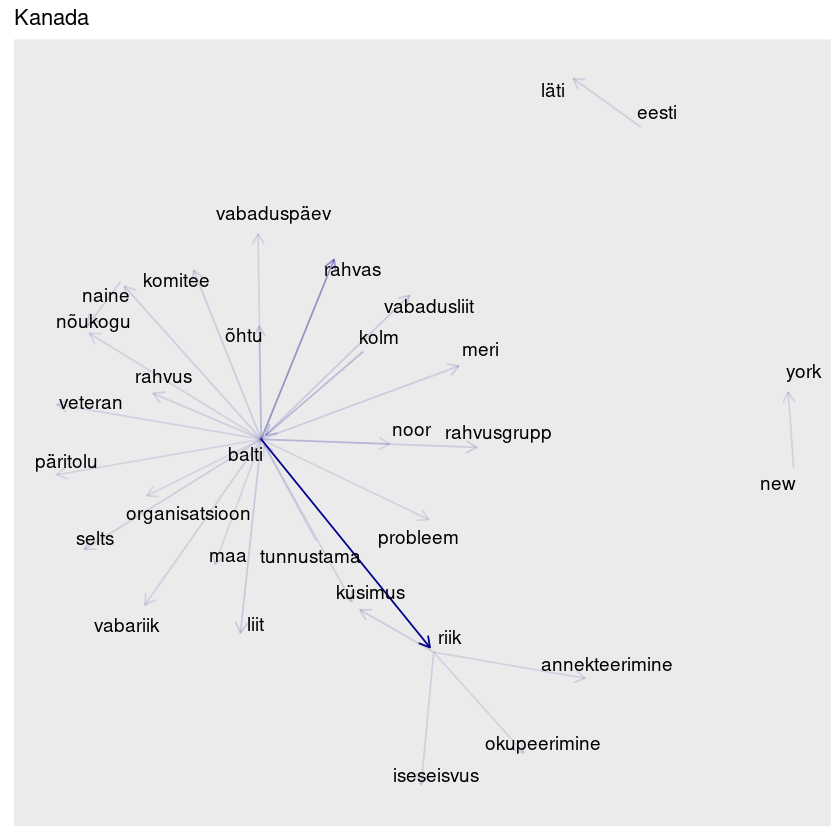

In [26]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_kanada, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("Kanada")

In [27]:
usa_ajalehed <- all_issues %>%
    filter(DocumentType=="NEWSPAPER") %>%
    filter(keyid=="vabaeestisona")

In [28]:
searchfile <- "balti_lemmad_usa.txt"
do_subset_search(searchterm=searchterm, searchfile=searchfile, usa_ajalehed, searchtype="lemmas", source="pages")

In [29]:
texts4 <- fread("balti_lemmad_usa.txt",header=F,sep="\t", quote="")[,.(id=V1,lemmas=V2)]
texts4[,DocumentID:=str_extract(id,"[^\\.]+")]
fileids_w_meta4 <- texts4 %>% select(id, DocumentID) %>% left_join(usa_ajalehed %>% select(keyid, year, month, DocumentID, zippath_sections, zippath_pages), by=c("DocumentID"))

In [30]:
usa_bigrammid <- get_concordances(searchterm=searchterm,texts=texts4,before=50,after=50,txt="lemmas",id="id")

In [31]:
usa_concs <- usa_bigrammid[, !c("id","nr","begin","end", "DocumentID")]

write.table(usa_concs, "usa_bigrammid.txt", sep="\t", quote = F, row.names = F)

In [32]:
usa_concs2 <- str_replace_all(usa_concs$context, "\\|", "_")

usa_concs3 <- as.data.frame(usa_concs2, header = TRUE)
colnames(usa_concs3) <- "context"
head(usa_concs3, 10)

,context
,<chr>
1,ti rõi va hävitamine . miks El kuulma Appihuudu ? balti komitee deklaratsioon maailm . hoiatus kommunism
2,oon maailm rahu vastu ja sama aeg j otsene rünnak balti rahvas vabadu j sele . see leping põhjal nõukogu-
3,jal nõukogu-j de Liidu_Liidud_Liit valitsus asuma balti nik_niki_nikide iseseisvus hävitamine . juuni kes
4,dama praegu selge ; et andma seaduslik alune_alus balti riiolmna igaüks ja konverents tagajärg ei saama o
5,pool miljon kalN . 1 kdetungijäte tääk olemasolu balti “ vaba Eesti sõna ” järgmine number ilmuma laupäe
6,"ündinu laps kui ka kuni 70 a . vanune vanake kogu balti riik tema transporteeriti raudteejaam , laadima l"
7,"] . ihl olema ainult algus metsik ettekavatsetud balti rahvas likvideerimine . 15,000,000 vang nõukogu k"
8,i abi esinema kõne . sõna - võtt olema tema teine balti rahvas 1 esindaja . aktus kujunema uhfcuslikukS k
9,kuvabadus ja ühesugune õiglus jaseadus rezhiinü . balti rahvas kõneleja ei olema_olnud raske see kohustus


In [33]:
bigrams_separated_usa <- usa_concs3 %>%
  unnest_tokens(bigram, context, token = "ngrams", n = 2, n_min = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

In [34]:
bigrams_filtered_usa <- bigrams_separated_usa %>%
  filter(!word1 %in% stopsonad$word) %>%
  filter(!word2 %in% stopsonad$word)

In [35]:
bigram_counts_usa <- bigrams_filtered_usa %>% 
  count(word1, word2, sort = TRUE)

In [36]:
bigram_graph_usa <- bigram_counts_usa %>%
  filter(row_number() <= 30) %>%
  graph_from_data_frame()

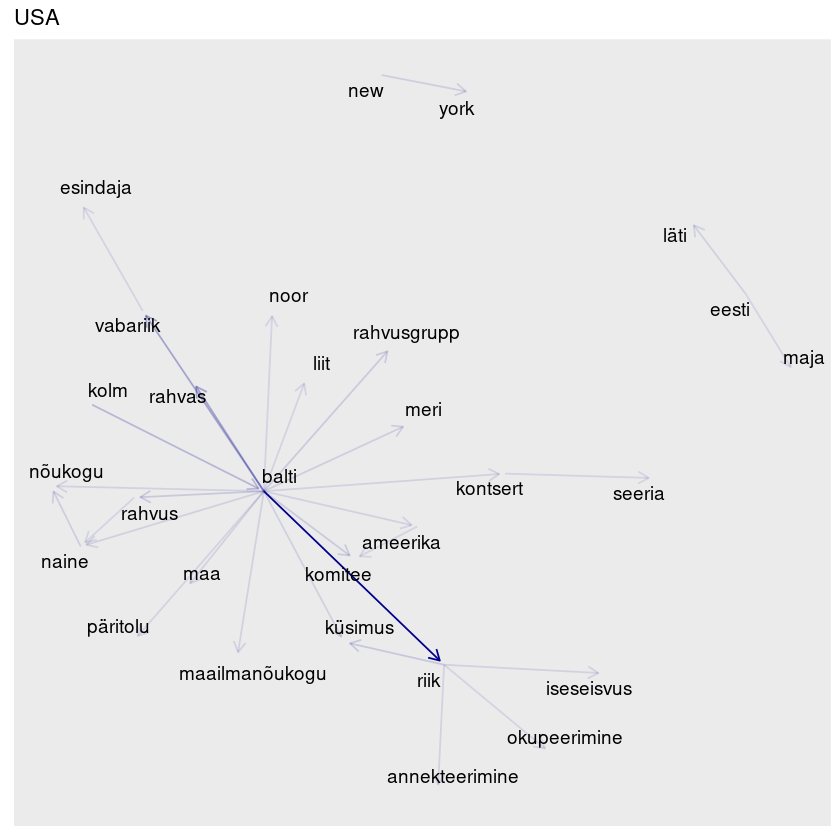

In [37]:
set.seed(2017)

a <- grid::arrow(type = "open", length = unit(.10, "inches"))

ggraph(bigram_graph_usa, layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a, end_cap = circle(.05, 'inches'), color = "darkblue") +
    geom_node_text(aes(label = name), repel = TRUE, size=4) +
ggtitle("USA")